# Applied Machine Learning: In-class exercise 02-2

## Goal

After this exercise, you should be able to define search spaces for learning algorithms and apply different hyperparameter optimization (HPO) techniques to search through the search space to find a well-performing hyperparameter configuration (HPC).

## Exercises

Again, we are looking at the german_credit dataset and the corresponding classification task. We want to train a k-NN model but ask ourselves what the best choice of k might be. Furthermore, we are not sure how to set other hyperparameters of the learner, e.g., whether we should scale the data or not. In this exercise, we conduct HPO for k-NN to automatically find a good HPC.

In [1]:
import pandas as pd
from sklearn.datasets import fetch_openml


X, y = fetch_openml("credit-g", version=1, as_frame=True, return_X_y=True)

X = pd.get_dummies(X, drop_first=True)

## Parameter spaces
Define a meaningful search space for the hyperparameters k and scale. You can check the scikit-learn documentation for KNeighborsClassifier for an overview of the k-NN classifier.

<details><summary>Hint 1: </summary>
In scikit-learn, hyperparameters are defined via dictionaries when setting up a search space. According to the docs of [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html):

> **`param_distributions`** `dict` or `list` of `dicts`
> Dictionary with parameters names (`str`) as keys and distributions or lists of parameters to try. Distributions must provide a `rvs` method for sampling (such as those from `scipy.stats.distributions`). If a list is given, it is sampled uniformly. If a list of dicts is given, first a dict is sampled uniformly, and then a parameter is sampled using that dict as above.

In addition, the search space is defined using a dictionary where keys are pipeline step names with double underscores (e.g., 'knn__n_neighbors') and values are the respective ranges or options.
</details>

<details><summary>Hint 2: </summary>
In this use case, we tune a `sklearn.pipeline.Pipeline` consisting of a scaling step and a `KNeighborsClassifier`. The hyperparameter n_neighbors corresponds to k, and we also tune whether to apply scaling or not. This is represented by the 'scaler' step being either a StandardScaler() or 'passthrough'. 
</details>


In [2]:
#===SOLUTION===

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier


# Build a pipeline:
# - 'scaler' step: either StandardScaler (if scaling is applied) or 'passthrough' (if not)
# - 'knn' step: KNeighborsClassifier where we will tune the number of neighbors
pipeline = Pipeline([
    # default: will be replaced by 'passthrough' if scaling is not desired
    ('scaler', StandardScaler()),  
    ('knn', KNeighborsClassifier())
])

# Define the hyperparameter search space
# 'knn__n_neighbors' corresponds to k in R (1 to 100)
# 'scaler' is either StandardScaler() (equivalent to scale = TRUE) or 'passthrough' (scale = FALSE)
param_distributions = {
    'scaler': [StandardScaler(), 'passthrough'],
    'knn__n_neighbors': list(range(1, 101))
}

## Hyperparameter optimization

Now, we want to tune the k-NN model using the search space from the previous exercise. As a resampling strategy, we use 3-fold cross-validation. The tuning strategy should be a random search. As a termination criterion, we choose 40 evaluations.
<details><summary>Hint 1: </summary>
The elements required for the tuning are:
    
* Task: German credit
    
* Algorithm: k-NN model defined in the pipeline

* Resampling: 3-fold cross-validation using cv=3

* Terminator: 40 evaluations using n_iter=40

* Search space: See previous exercise


* Performance measure: We use the default scoring metric of RandomizedSearchCV (mean accuracy). To report classification error, subtract the accuracy from 1.

  
* The tuning is performed with `RandomizedSearchCV`.    
</details>

In [3]:
#===SOLUTION===

from sklearn.model_selection import RandomizedSearchCV


random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=40,  # 40 different HPCs
    cv=3,  # 3-fold cross-validation
    random_state=42,
    n_jobs=4  # Parallel processing with 4 jobs
)

# Run hyperparameter optimization
random_search.fit(X, y)

# Retrieve and print the best results.
# Note: In scikit-learn, best_score_ is the mean accuracy over the CV folds,
# so we subtract it from 1 to report the classification error.
best_score = random_search.best_score_
best_params = random_search.best_params_
print(f"Best classification error: {1 - best_score:.4f}")
print(f"Best hyperparameters: {best_params}")

Best classification error: 0.2490
Best hyperparameters: {'scaler': StandardScaler(), 'knn__n_neighbors': 16}


## Analyzing the tuning archive

Inspect the archive of hyperparameters evaluated during the tuning process using `RandomSearchCV.cv_results_`. 
Create a simple plot to illustrate the association between the hyperparameter $k$ and the estimated classification error.

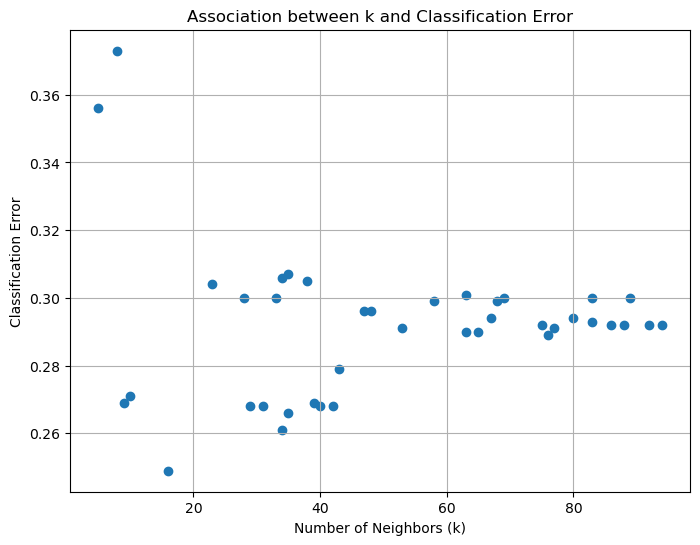

In [4]:
#===SOLUTION===

import matplotlib.pyplot as plt

# Extract candidate k values and the corresponding mean accuracy from RandomizedSearchCV results
k_values = random_search.cv_results_['param_knn__n_neighbors']
# Convert accuracy to classification error
classification_error = 1 - random_search.cv_results_['mean_test_score']

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(k_values, classification_error)
plt.xlabel(f'Number of Neighbors (k)')
plt.ylabel(f'Classification Error')
plt.title(f'Association between k and Classification Error')
plt.grid(True)
plt.show()


## Visualizing hyperparameters

To see how effective the tuning was, it is useful to look at the effect of the hyperparameters on the model's performance. It also helps us understand how important different hyperparameters are. Therefore, access the archive of the tuning instance and visualize the effect.

<details><summary>Hint:</summary>
    You need to plot two plots. In the first one, you demonstrate how $k$ affects the classification error (in fact you have done above). In the second one, you demonstrate how the "scaling"-vs-"non-scaling" affects the classification error.
</details>


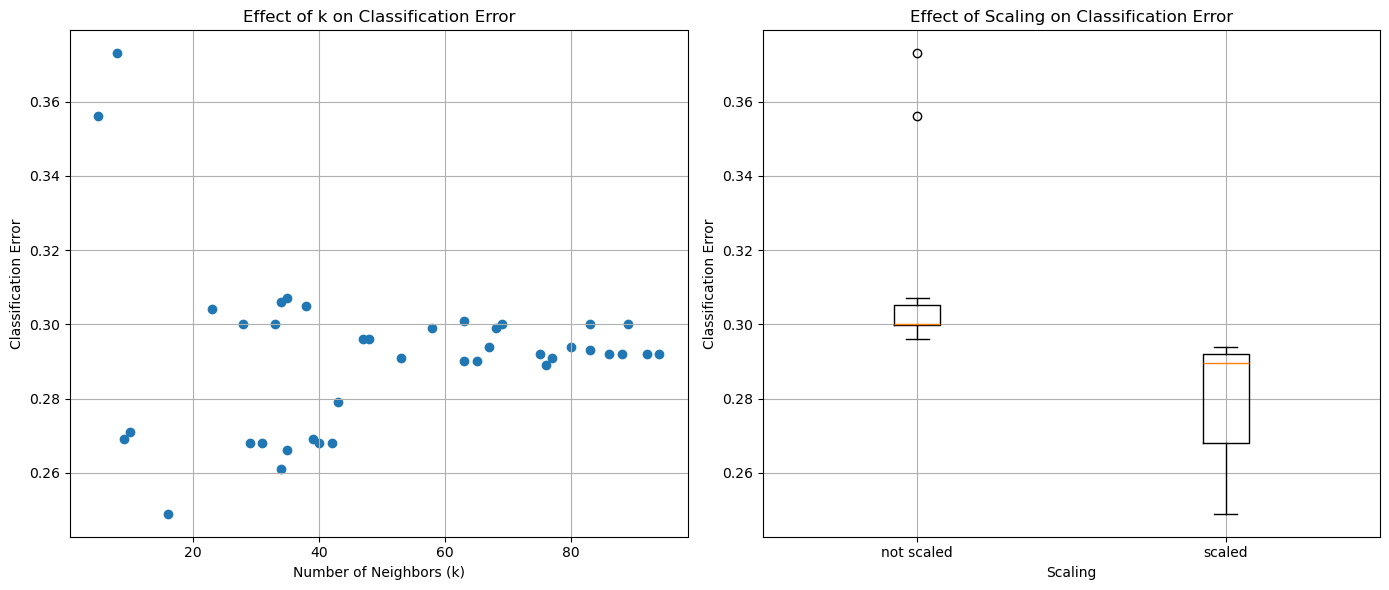

In [5]:
#===SOLUTION===

# Extract tuning archive information from RandomizedSearchCV results
cv_results = random_search.cv_results_
k_values = cv_results['param_knn__n_neighbors']
mean_test_scores = cv_results['mean_test_score']
# Compute classification error as 1 - accuracy
classification_errors = [1 - score for score in mean_test_scores]
scaler_values = cv_results['param_scaler']

# Group classification errors by the scaling option using built-in dictionaries.
grouped_errors = {"scaled": [], "not scaled": []}
for scaler, error in zip(scaler_values, classification_errors):
    label = "scaled" if isinstance(scaler, StandardScaler) else "not scaled"
    grouped_errors[label].append(error)

# Create a figure with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot: k vs. Classification Error in the first subplot
axes[0].scatter(k_values, classification_errors)
axes[0].set_xlabel("Number of Neighbors (k)")
axes[0].set_ylabel("Classification Error")
axes[0].set_title("Effect of k on Classification Error")
axes[0].grid(True)

# Box plot: Scaling vs. Classification Error in the second subplot
# Arrange bars in the order: ['not scaled', 'scaled']
data_to_plot = [grouped_errors["not scaled"], grouped_errors["scaled"]]
labels = ["not scaled", "scaled"]
axes[1].boxplot(data_to_plot, labels=labels)
axes[1].set_xlabel("Scaling")
axes[1].set_ylabel("Classification Error")
axes[1].set_title("Effect of Scaling on Classification Error")
axes[1].grid(True)

plt.tight_layout()
plt.show()


### Discuss the figures you obtained

What is your observation?

===SOLUTION===

The hyperparameter $k$ seem to have a significant impact on the performance of k-NN classifier, while "scaling" has a moderate impact.

## Hyperparameter dependencies

When defining a hyperparameter search space, we sometimes encounter nested search spaces, also called hyperparameter dependencies. One example is Support Vector Machines (SVMs). For instance, the hyperparameter degree is only relevant if the hyperparameter kernel is set to "polynomial". Therefore, we only need to evaluate different configurations for degree when the candidate configuration uses a polynomial kernel.

Construct a search space for an SVM with the hyperparameters kernel (with candidate values "polynomial" and "radial") and degree (an integer from 1 to 3, but only relevant for the "polynomial" kernel), and account for this dependency structure.

```python
# Example of how you might use this with GridSearchCV:
# from sklearn.model_selection import GridSearchCV
# svc = SVC()
# Now assumed that you have defined `svm_search_space`.
# grid = GridSearchCV(svc, svm_search_space, cv=3)
```

<details><summary>Hint 1:</summary>
In scikit-learn, such dependencies are handled by specifying the search space as a list of dictionaries. Each dictionary can represent a separate branch of the search, allowing conditional inclusion of parameters based on other parameter values.
</details>

In [6]:
#===SOLUTION===

# Define the search space with hyperparameter dependency:
# - When kernel is "polynomial", tune degree from 1 to 3.
# - When kernel is "radial", degree is not applicable.
svm_search_space = [
    {"kernel": "polynomial", "degree": [1, 2, 3]},
    {"kernel": "radial"}
]

## Hyperparameter transformations

When tuning non-negative hyperparameters with a broad range, using a logarithmic scale can be more efficient. This approach works especially well if we want to test many small values, but also a few very large ones. By selecting values on a logarithmic scale and then exponentiating them, we ensure a concentrated exploration of smaller values while still considering the possibility of very large values. This enables a targeted and efficient search for optimal hyperparameter configurations.


<details><summary>Hint 1:</summary>
To manually define a hyperparameter with a logarithmic transformation, we use `scipy.stats.loguniform(a, b)` with the lower bound `a` and upper bound `b`. This is equivalent to sampling from `Uniform(log(a), log(b))` and then applying `exp` to the sampled value. See more details in the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.loguniform.html).
</details>

<details><summary>Hint 2:</summary>
The cost corresponds to the hyperparameter `C` in `sklearn.svm.SVC`.
</details>


In [7]:
#===SOLUTION===
from scipy import stats


# Define a search space for the 'C' parameter (commonly referred to as 'cost')
# using a log-uniform distribution between 1e-5 and 1e5
search_space = {'C': stats.loguniform(1e-5, 1e5)}

print(f"{search_space}")

{'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x154ccb910>}


## Summary

* In this use-case we learned how to define search spaces for learner hyperparameters.

* Based on this search space, we defined a tuning strategy to try a number of random configurations.

* We visualized the tested configurations to get an idea how the hyperparameter effect the performance of our learner.

* We learned about scale transformations in tuning.

* Finally we added a transformation to favor a certain range in the parameter space.